In [337]:
import warnings
warnings.filterwarnings('ignore')

In [338]:
from imblearn.ensemble import BalancedRandomForestClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [339]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

In [340]:
pitchers_df = pd.read_csv('Combined CSV\Pitchers_Complete.csv')


In [341]:
pitchers_df.shape

(9427, 34)

In [342]:
pitchers_df.columns

Index(['playerID', 'nameFirst', 'nameLast', 'weight', 'height', 'bats_L',
       'bats_R', 'throws_L', 'throws_R', 'Seasons', 'Wins', 'Losses', 'Games',
       'Pitch_Starts', 'Complete_Games', 'Shutouts', 'Saves', 'Outs_Pitched',
       'Hits', 'Earned_Runs', 'Home_Runs', 'Walks', 'Strikeouts',
       'Batters_Faced', 'Games_Finished', 'Runs_Allowed', 'finalGame',
       'Retired_Years', 'inducted', 'yearID', 'Total_Games', 'Games_Started',
       'Primary_Position', 'Hall_Eligible'],
      dtype='object')

In [343]:
pitchers_df.head()

,playerID,nameFirst,nameLast,weight,height,bats_L,bats_R,throws_L,throws_R,Seasons,...,Games_Finished,Runs_Allowed,finalGame,Retired_Years,inducted,yearID,Total_Games,Games_Started,Primary_Position,Hall_Eligible
0,aardsda01,David,Aardsma,215.0,75.0,0,1,0,1,9,...,141,169,2015-08-23,6.720548,0,0.0,331,0.0,Pitcher,0
1,aasedo01,Don,Aase,190.0,75.0,0,1,0,1,13,...,235,503,1990-10-03,31.624658,0,0.0,448,91.0,Pitcher,1
2,abadfe01,Fernando,Abad,235.0,74.0,1,0,1,0,12,...,101,155,2021-10-01,0.608219,0,0.0,400,6.0,Pitcher,0
3,abbeybe01,Bert,Abbey,175.0,71.0,0,1,0,1,7,...,14,442,1896-09-23,125.712329,0,0.0,79,0.0,Pitcher,0
4,abbotco01,Cory,Abbott,210.0,73.0,0,1,0,1,1,...,2,15,2021-10-02,0.605479,0,0.0,8,1.0,Pitcher,0


In [344]:
pitchers_train_model = pitchers_df[pitchers_df['Hall_Eligible']==1]
pitchers_train_model.head()

,playerID,nameFirst,nameLast,weight,height,bats_L,bats_R,throws_L,throws_R,Seasons,...,Games_Finished,Runs_Allowed,finalGame,Retired_Years,inducted,yearID,Total_Games,Games_Started,Primary_Position,Hall_Eligible
1,aasedo01,Don,Aase,190.0,75.0,0,1,0,1,13,...,235,503,1990-10-03,31.624658,0,0.0,448,91.0,Pitcher,1
6,abbotgl01,Glenn,Abbott,200.0,78.0,0,1,0,1,13,...,13,707,1984-08-08,37.780822,0,0.0,248,204.0,Pitcher,1
7,abbotji01,Jim,Abbott,200.0,75.0,1,0,1,0,12,...,5,880,1999-07-21,22.821918,0,0.0,263,254.0,Pitcher,1
9,abbotpa01,Paul,Abbott,185.0,75.0,0,1,0,1,13,...,17,421,2004-08-07,17.769863,0,0.0,162,112.0,Pitcher,1
10,aberal01,Al,Aber,195.0,74.0,1,0,1,0,10,...,76,205,1957-09-11,64.706849,0,0.0,168,30.0,Pitcher,1


In [345]:
scale_pos_weight = (pitchers_train_model.inducted.value_counts()[0])/pitchers_train_model.inducted.value_counts()[1]
print(scale_pos_weight)

22.014492753623188


In [346]:
# Getting data ready for machine learning
data = pitchers_train_model.drop(['inducted', 
                                  'playerID', 
                                  'nameFirst', 
                                  'nameLast', 
                                  'finalGame',
                                  'yearID',
                                  'Primary_Position',
                                  'Hall_Eligible'], axis=1)
data.fillna(0, inplace=True)
data['Batters_Faced']=pd.to_numeric(data['Batters_Faced'])
target = pitchers_train_model['inducted']
target.fillna(0, inplace=True)
feature_names = data.columns

In [347]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=42)
X_scaler = StandardScaler().fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [348]:
len(X_test_scaled)

397

In [349]:
#CLF = Classifier
clf = BalancedRandomForestClassifier(n_estimators=100, random_state=1)
clf = clf.fit(X_train_scaled, y_train)
clf.score(X_test_scaled, y_test)

0.9219143576826196

In [350]:
y_predicted = clf.predict(X_test_scaled)
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.metrics import classification_report_imbalanced
print(confusion_matrix(y_test, y_predicted))

predictions_df = pd.concat([pd.DataFrame(X_test_scaled),              
                            pd.DataFrame(dict(predicted= y_predicted,actual=y_test
                            )).reset_index(drop=True)], axis=1)

[[350  31]
 [  0  16]]


In [351]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_predicted))

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.92      1.00      0.96      0.96      0.91       381
          1       0.34      1.00      0.92      0.51      0.96      0.93        16

avg / total       0.97      0.92      1.00      0.94      0.96      0.91       397



In [352]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, y_predicted) 

0.9593175853018372

In [353]:
# List the features sorted in descending order by feature importance
sorted(zip(clf.feature_importances_, data.columns), reverse=True)

[(0.1586112672389697, 'Wins'),
 (0.1365229854734174, 'Outs_Pitched'),
 (0.10715460250161965, 'Shutouts'),
 (0.10489289409961249, 'Strikeouts'),
 (0.06764524310560809, 'Batters_Faced'),
 (0.052056718413331315, 'Complete_Games'),
 (0.05161646969595953, 'Pitch_Starts'),
 (0.04424683075999263, 'Hits'),
 (0.04042479652192527, 'Runs_Allowed'),
 (0.038932207965740095, 'Walks'),
 (0.033800190863598985, 'Games'),
 (0.03249699219842107, 'Saves'),
 (0.02271652468224265, 'Losses'),
 (0.022187582229952818, 'Total_Games'),
 (0.020098856798359245, 'Games_Finished'),
 (0.012149858608534356, 'Games_Started'),
 (0.011251825472080932, 'Retired_Years'),
 (0.010121353657768043, 'Earned_Runs'),
 (0.009412998463399557, 'weight'),
 (0.0063490938225452005, 'Home_Runs'),
 (0.006227130680824808, 'Seasons'),
 (0.004449250515509851, 'height'),
 (0.0027141570712988197, 'bats_L'),
 (0.002372503913122167, 'throws_L'),
 (0.0010085867075912511, 'throws_R'),
 (0.0005390785385742566, 'bats_R')]

<BarContainer object of 26 artists>

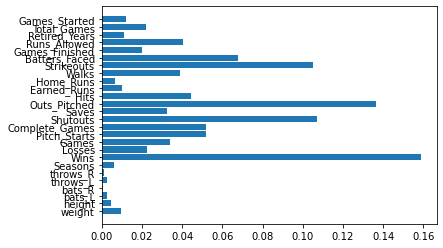

In [354]:
plt.barh(feature_names,clf.feature_importances_)

In [355]:
predictions_df

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,predicted,actual
0,-0.143402,0.644215,-0.572503,0.658189,-0.647725,0.650338,0.987501,2.779308,1.410357,0.909812,...,2.712745,2.380524,2.381079,-0.737260,1.455326,-0.244226,0.937065,2.489993,1,1
1,-1.882697,-2.399975,-0.572503,0.658189,-0.647725,0.650338,0.750668,0.255197,0.268212,2.509055,...,-0.489028,0.082060,-0.157516,3.763509,-0.276225,0.208753,2.438233,-0.905380,0,0
2,-0.391872,0.209330,-0.572503,0.658189,-0.647725,0.650338,0.513835,1.609598,0.789190,0.286659,...,0.782909,0.534866,1.283611,-0.334687,0.957828,0.942486,0.302998,1.253449,1,0
3,-1.137285,-1.095322,-0.572503,0.658189,-0.647725,0.650338,-1.143998,-1.053031,-1.054272,-1.533169,...,-0.883767,-0.833882,-1.061113,-0.688951,-1.066622,0.309209,-1.528751,-0.604784,0,0
4,0.105069,-0.660438,-0.572503,0.658189,-0.647725,0.650338,-1.143998,0.870834,0.689002,-0.182085,...,0.641208,0.452225,0.806970,-0.197812,0.410796,1.713491,0.102481,0.665919,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392,-0.888814,-0.660438,-0.572503,0.658189,1.543866,-1.537663,-0.670331,-1.083813,-1.414950,-0.579138,...,-1.170543,-1.155839,-1.166817,-0.173657,-1.197996,-0.501676,-0.623715,-1.076174,0,0
393,-1.882697,-1.095322,-0.572503,0.658189,-0.647725,0.650338,-1.143998,-0.191139,-0.212692,-0.849355,...,0.610843,-0.635887,-0.120252,-0.487665,0.005906,1.527134,-0.883845,0.030568,0,0
394,-0.888814,-1.095322,1.746717,-1.519320,1.543866,-1.537663,2.645334,1.624989,2.031523,0.970473,...,1.876033,1.493850,1.901272,-0.423253,1.791298,0.266300,1.115905,2.066426,1,0
395,-0.143402,-1.095322,-0.572503,0.658189,-0.647725,0.650338,0.513835,0.193634,0.228136,1.516421,...,0.212730,0.471163,0.222433,2.201525,0.096360,-0.040705,1.533197,-0.181216,0,0


In [356]:
import os
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [357]:
# fit model to training data
XGmodel = XGBClassifier(scale_pos_weight=1)
XGmodel.fit(X_train_scaled, y_train)
y_pred = XGmodel.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

In [358]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))
predictions_df = pd.concat([pd.DataFrame(X_test_scaled),
#                            .copy().assign(
                           pd.DataFrame(dict(
    predicted= y_pred,
    actual=y_test
)).reset_index(drop=True)
                           ], axis=1)
actual_inductees = predictions_df.loc[predictions_df.actual==1]
predictions_for_actual_inductees = actual_inductees.predicted.value_counts()
print(predictions_for_actual_inductees)


[[375   6]
 [  5  11]]
1    11
0     5
Name: predicted, dtype: int64


<BarContainer object of 26 artists>

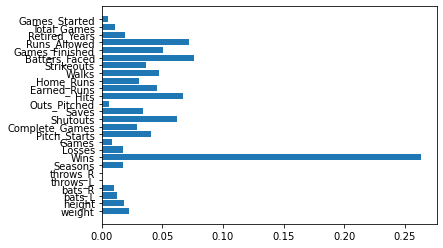

In [359]:
plt.barh(feature_names,XGmodel.feature_importances_)

In [360]:
# Run all data through the model to determine who should be in the hall of fame.
data_total = pitchers_df.drop(['inducted', 
                                  'playerID', 
                                  'nameFirst', 
                                  'nameLast', 
                                  'finalGame',
                                  'yearID',
                                  'Primary_Position',
                                  'Hall_Eligible'], axis=1)
data_total.fillna(0, inplace=True)
data_total['Batters_Faced'].fillna(0, inplace=True)
data_total['Batters_Faced']=pd.to_numeric(data['Batters_Faced'])
# data_total.head()
data_total=data_total.fillna(0)
data_total.head()

,weight,height,bats_L,bats_R,throws_L,throws_R,Seasons,Wins,Losses,Games,...,Earned_Runs,Home_Runs,Walks,Strikeouts,Batters_Faced,Games_Finished,Runs_Allowed,Retired_Years,Total_Games,Games_Started
0,215.0,75.0,0,1,0,1,9,16,18,331,...,160,41,183,340,0.0,141,169,6.720548,331,0.0
1,190.0,75.0,0,1,0,1,13,66,60,448,...,468,89,457,641,4730.0,235,503,31.624658,448,91.0
2,235.0,74.0,1,0,1,0,12,8,29,400,...,146,43,123,290,0.0,101,155,0.608219,400,6.0
3,175.0,71.0,0,1,0,1,7,22,40,79,...,285,18,192,161,0.0,14,442,125.712329,79,0.0
4,210.0,73.0,0,1,0,1,1,0,0,7,...,13,7,11,12,0.0,2,15,0.605479,8,1.0


In [361]:
data_total_scaler = StandardScaler().fit(data_total)
data_total_scaled = data_total_scaler.transform(data_total)
data_total_predicted = XGmodel.predict(data_total_scaled)

In [362]:
pitchers_predict_df = pd.concat([pitchers_df, pd.Series(data_total_predicted)], axis=1)
pitchers_predict_df = pitchers_predict_df.rename(columns={0:'model_predict'})
pitchers_predict_df['Comparison']=pitchers_predict_df['inducted']==pitchers_predict_df['model_predict']
pitchers_predict_df.head()

,playerID,nameFirst,nameLast,weight,height,bats_L,bats_R,throws_L,throws_R,Seasons,...,finalGame,Retired_Years,inducted,yearID,Total_Games,Games_Started,Primary_Position,Hall_Eligible,model_predict,Comparison
0,aardsda01,David,Aardsma,215.0,75.0,0,1,0,1,9,...,2015-08-23,6.720548,0,0.0,331,0.0,Pitcher,0,0,True
1,aasedo01,Don,Aase,190.0,75.0,0,1,0,1,13,...,1990-10-03,31.624658,0,0.0,448,91.0,Pitcher,1,0,True
2,abadfe01,Fernando,Abad,235.0,74.0,1,0,1,0,12,...,2021-10-01,0.608219,0,0.0,400,6.0,Pitcher,0,0,True
3,abbeybe01,Bert,Abbey,175.0,71.0,0,1,0,1,7,...,1896-09-23,125.712329,0,0.0,79,0.0,Pitcher,0,0,True
4,abbotco01,Cory,Abbott,210.0,73.0,0,1,0,1,1,...,2021-10-02,0.605479,0,0.0,8,1.0,Pitcher,0,0,True


In [363]:
from sklearn.neighbors import KNeighborsClassifier

In [364]:
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(metric='euclidean')

In [365]:
y_pred = knn.predict(X_test_scaled)

In [366]:
from imblearn.over_sampling import ADASYN 

In [367]:
ada = ADASYN()
X_ada, y_ada = ada.fit_sample(X_train_scaled,y_train)

In [368]:
clf_ada = BalancedRandomForestClassifier(random_state=0)
clf_ada = clf.fit(X_ada, y_ada)
clf.score(X_test_scaled, y_test)

0.9521410579345088

In [369]:
y_predicted_ada = clf_ada.predict(X_test_scaled)
# from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_predicted_ada))

predictions_df = pd.concat([pd.DataFrame(X_test_scaled),
#                            .copy().assign(
                           pd.DataFrame(dict(
    predicted= y_predicted_ada,
    actual=y_test
)).reset_index(drop=True)
                           ], axis=1)
# pd.Series(y_test).value_counts()#[:20]
actual_inductees = predictions_df.loc[predictions_df.actual==1]
predictions_for_actual_inductees = actual_inductees.predicted.value_counts()


[[364  17]
 [  2  14]]


<BarContainer object of 26 artists>

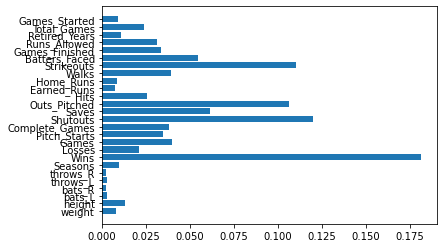

In [370]:
plt.barh(feature_names,clf_ada.feature_importances_)

In [371]:
from imblearn.combine import SMOTETomek
smote_tomek = SMOTETomek(random_state=0)
X_resampled, y_resampled = smote_tomek.fit_resample(X_train_scaled,y_train)
x_GB = XGBClassifier(scale_pos_weight=1)
x_GB.fit(X_resampled, y_resampled)
#y_pred_smote_tomek
y_GB = x_GB.predict(X_test_scaled)
print(len(X_resampled), len(y_resampled))

2274 2274


In [372]:
X_resampled_df = pd.DataFrame(X_resampled)
X_resampled_df.shape

(2274, 26)

In [373]:
y_GB.shape

(397,)

In [374]:
y_test.shape

(397,)

In [375]:
y_sample_check = pd.DataFrame(dict(predicted= y_GB,actual=y_test)).reset_index(drop=True)
y_sample_check.shape

(397, 2)

In [376]:
predictions_df = pd.concat([pd.DataFrame(X_test_scaled),
                           pd.DataFrame(dict(
    predicted= y_GB,
    actual=y_test)).reset_index(drop=True) ], axis=1)
actual_inductees = predictions_df.loc[predictions_df.actual==1]
predictions_for_actual_inductees = actual_inductees.predicted.value_counts()
print(classification_report(y_test,y_GB))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       381
           1       0.48      0.75      0.59        16

    accuracy                           0.96       397
   macro avg       0.73      0.86      0.78       397
weighted avg       0.97      0.96      0.96       397

